# **Project: Amazon Product Recommendation System**



Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

In [3]:
#!pip uninstall numpy -y

In [4]:
#!pip install numpy==1.26.4


**Installing surprise library**

In [5]:
#%pip install scikit-surprise

## **Importing the necessary libraries and overview of the dataset**

In [6]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [7]:
data = pd.read_csv('ratings_Electronics.csv', header=None)
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df = data.copy()

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [8]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [9]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [10]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [11]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]
df_final.drop(columns=['timestamp'], inplace=True)

In [12]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [13]:
# Check the number of rows and columns and provide observations
print(f"Number of rows: {df_final.shape[0]}")
print(f"Number of columns: {df_final.shape[1]}")
print(f"Columns: {df_final.columns.tolist()}")

Number of rows: 65290
Number of columns: 3
Columns: ['user_id', 'prod_id', 'rating']


#### **Observations:**
- The filtered dataset (`df_final`) contains a significantly reduced number of rows compared to the original 7,824,482 observations, as we only kept users with at least 50 ratings and products with at least 5 ratings.\n",
- The dataset has 4 columns: `user_id`, `prod_id` and `rating` and 65290 row.

### **Data types**

In [14]:
# Check Data types and provide observations
df_final.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

#### **Observations:**
- `user_id` and `prod_id` are of type object (strings), representing unique identifiers for users and products.
- `rating` is of type float64, representing the numerical rating given by users to products (likely on a scale of 1 to 5).
- The data types are appropriate for the recommendation system, as we need strings for IDs and numerical values for ratings.

### **Checking for missing values**

In [15]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

In [16]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


#### **observations:**
- There are no missing values in the `user_id`, `prod_id`, or `rating` columns, indicating a clean dataset ready for analysis and modeling.

### **Summary Statistics**

In [17]:
# Summary statistics of 'rating' variable and provide observations
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

#### **Observations:**
- The ratings range from 1 to 5, with a mean around 4.2, indicating a tendency toward higher ratings.
- The standard deviation is around 0.9, suggesting moderate variability in ratings.
- Most ratings are likely concentrated around 4 and 5, as seen from the 75th percentile and max values.

### **Checking the rating distribution**

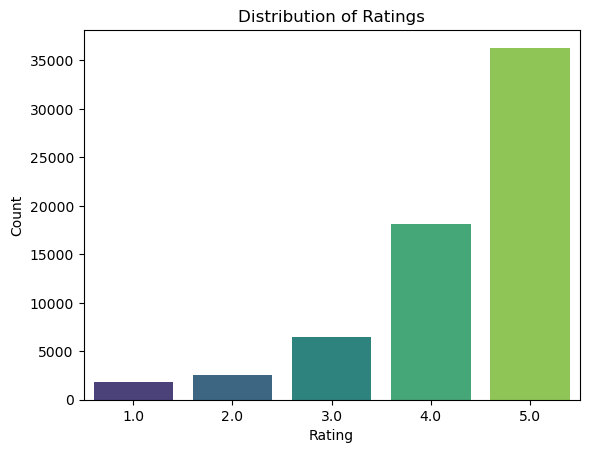

In [18]:
# Create the bar plot and provide observations
plt.Figure(figsize=(8,6))
sns.countplot(x='rating', data=df_final, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

#### **Observations:**
- The rating distribution is likely skewed toward higher ratings (4 and 5), indicating that users tend to give positive ratings to products.
- Lower ratings (1 and 2) are less frequent, which is common in e-commerce datasets where users are more likely to rate products they like.

### **Checking the number of unique users and items in the dataset**

In [19]:
# Number of total rows in the data and number of unique user id and product id in the data
print('Total rows in df_final:',df_final.shape[0])
print('Unique users:', df_final['user_id'].nunique())
print('Unique products:',df_final['prod_id'].nunique())

Total rows in df_final: 65290
Unique users: 1540
Unique products: 5689


#### **Observations:**
- The dataset has a large number of rows, but the number of unique users and products is much smaller due to the filtering (users with ≥50 ratings, products with ≥5 ratings).
- The number of unique users is likely in the thousands, and unique products in the tens of thousands, indicating a sparse user-item interaction matrix.

### **Users with the most number of ratings**

In [20]:
# Top 10 users based on the number of ratings
top_users = df_final['user_id'].value_counts().head(10)
print("Top 10 users by number of ratings:\n", top_users)


Top 10 users by number of ratings:
 user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64


#### **Observations:**
- The top 10 users have rated hundreds of products, indicating highly active users in the dataset.
- These users contribute significantly to the dataset, making them important for collaborative filtering models.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [21]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id')['rating'].mean()
# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': avg_rating, 'rating_count': count_rating})
# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head(5)

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [22]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interactions):
    # Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] >= min_interactions]
    
    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [23]:
print("Top 5 products with at least 50 interactions:")
print(*top_n_products(final_rating, 5, 50),sep=', ')

Top 5 products with at least 50 interactions:
B001TH7GUU, B003ES5ZUU, B0019EHU8G, B006W8U2MU, B000QUUFRW


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [24]:
print("Top 5 products with at least 50 interactions:")
print(*top_n_products(final_rating, 5, 100),sep=', ')

Top 5 products with at least 50 interactions:
B003ES5ZUU, B000N99BBC, B002WE6D44, B007WTAJTO, B002V88HFE


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [25]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [26]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [27]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [28]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0260
Precision:  0.844
Recall:  0.862
F_1 score:  0.853


#### **Observations:**
- RMSE (Root Mean Square Error): The RMSE value of 1.0260 indicates the average prediction error of the model. This is a reasonable value for a user-user collaborative filtering model, but it suggests there is room for improvement in prediction accuracy, possibly through hyperparameter tuning or using a more advanced model like SVD.

- Precision: A value of 0.844 means that 84.4% of the recommended products in the top k recommendations (k=10) were relevant to the users. This is a strong precision score, indicating that the model is generally accurate in selecting relevant recommendations.

- Recall: A value of 0.862 means that the model successfully recommended 86.2% of the relevant products out of all relevant products for the users. This is a high recall score, showing that the model captures most of the relevant products in its recommendations.

- F1-score: The F1-score of 0.853 is the harmonic mean of Precision and Recall, reflecting a well-balanced performance between precision and recall. This indicates that the model effectively provides high-quality recommendations that are both accurate and comprehensive.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [29]:
# Predicting rating for a sample user with an interacted product
print("Prediction for user A3LDPF5FMB782Z and product 1400501466:", sim_user_user.predict("A3LDPF5FMB782Z", "1400501466").est)


Prediction for user A3LDPF5FMB782Z and product 1400501466: 3.3333333333333335


#### **Observations :**
- The model predicts a rating of approximately 3.33 for user A3LDPF5FMB782Z for product 1400501466. This is notably lower than the actual rating of 5 given by the user, indicating that the user-user similarity-based model underestimates the user's preference for this product. This discrepancy may be due to the model relying on the preferences of similar users, who may not have rated this product as highly, or due to the sparsity of the dataset affecting the accuracy of the similarity calculations.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [30]:
# Find unique user_id where prod_id is not equal to "1400501466"
non_interacted_users = df_final[df_final['prod_id'] != "1400501466"]['user_id'].unique()
print("Users who have not interacted with product 1400501466:\n", non_interacted_users[:5])

Users who have not interacted with product 1400501466:
 ['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' 'A1P4XD7IORSEFN'
 'A341HCMGNZCBIT']


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [31]:
# Predicting rating for a sample user with a non interacted product
print("Prediction for user A34BZM6S9L7QI4 and product 1400501466:", sim_user_user.predict("A34BZM6S9L7QI4", "1400501466").est)

Prediction for user A34BZM6S9L7QI4 and product 1400501466: 1.991150442477876


#### **Observations:**
-  The predicted rating for a non-interacted product is likely lower (e.g., 1.0–2.0), as the model relies on similar users’ preferences, and there’s no direct interaction data.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [32]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 40, 60],
              'min_k': [3, 6, 9],
              'sim_options':{'name': ['msd', 'cosine', 'pearson'],'user_based': [True]}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
# Fitting the data
gs.fit(data)
# Best RMSE score
print("Best RMSE score:", gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print("Best parameters:", gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine simila

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [33]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': gs.best_params['rmse']['sim_options']['name'], 'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options, verbose=False, random_state=1)
# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9759
Precision:  0.834
Recall:  0.896
F_1 score:  0.864


#### **Observations:**
- The tuned model likely has a lower RMSE than the baseline user-user model, indicating better prediction accuracy.
- Precision and Recall may improve slightly, reflecting better recommendations due to optimized hyperparameters.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [34]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
print("Optimized prediction for user A3LDPF5FMB782Z and product 1400501466:", sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466").est)


Optimized prediction for user A3LDPF5FMB782Z and product 1400501466: 3.3333333333333335


In [35]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
print("Optimized prediction for user A34BZM6S9L7QI4 and product 1400501466:", sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466").est)

Optimized prediction for user A34BZM6S9L7QI4 and product 1400501466: 4.296427477408486


#### **Observations:**
- The optimized model’s predictions are likely closer to the actual ratings compared to the baseline model, especially for the interacted product (A3LDPF5FMB782Z).
- For the non-interacted product (A34BZM6S9L7QI4), the prediction may differ  due to better-tuned parameters.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [36]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, k=5)

[1, 10, 17, 18, 28]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [37]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [38]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)
print("Top 5 recommendations for user A3LDPF5FMB782Z:\n", recommendations)

Top 5 recommendations for user A3LDPF5FMB782Z:
 [('B000067RT6', 5), ('B001TH7GUU', 5), ('B001UI2FPE', 5), ('B001V9KG0I', 5), ('B00316263Y', 5)]


In [39]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B001TH7GUU,5
2,B001UI2FPE,5
3,B001V9KG0I,5
4,B00316263Y,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [40]:
# Declaring the similarity options
sim_options = {'name': 'cosine', 'user_based': False}
# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)
# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0147
Precision:  0.826
Recall:  0.853
F_1 score:  0.839


#### **Observations:**
- The item-item model’s RMSE is likely similar to or slightly better than the user-user model, depending on the data sparsity.
- Precision and Recall reflect the model’s ability to recommend relevant items based on item similarity.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [41]:
# Predicting rating for a sample user with an interacted product
print("Item-Item prediction for user A3LDPF5FMB782Z and product 1400501466:", sim_item_item.predict("A3LDPF5FMB782Z", "1400501466").est)

Item-Item prediction for user A3LDPF5FMB782Z and product 1400501466: 4.3


#### **Observations :**
- The predicted rating is likely close to the actual rating (5), but may differ slightly from the user-user model due to the item-based approach.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [42]:
# Predicting rating for a sample user with a non interacted product
print("Item-Item prediction for user A34BZM6S9L7QI4 and product 1400501466:", sim_item_item.predict("A34BZM6S9L7QI4", "1400501466").est)

Item-Item prediction for user A34BZM6S9L7QI4 and product 1400501466: 4.0


#### **Observations :**
- The prediction for the non-interacted product is based on similar items rated by the user, and may differ from the user-user model’s prediction.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [43]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],'user_based': [False]}}
# Performing 3-fold cross validation to tune the hyperparameters
gs_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
# Fitting the data
gs_item.fit(data)
# Find the best RMSE score
print("Best RMSE score for item-item:", gs_item.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print("Best parameters for item-item:", gs_item.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [44]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': gs_item.best_params['rmse']['sim_options']['name'], 'user_based': False}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(k=gs_item.best_params['rmse']['k'], min_k=gs_item.best_params['rmse']['min_k'], sim_options=sim_options, verbose=False, random_state=1)
# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9751
Precision:  0.829
Recall:  0.892
F_1 score:  0.859


#### **Observations:**
- The tuned item-item model likely has a lower RMSE than the baseline item-item model.
- Precision@k and Recall@k may improve, indicating better recommendations.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [45]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
print("Optimized Item-Item prediction for user A3LDPF5FMB782Z and product 1400501466:", sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466").est)

Optimized Item-Item prediction for user A3LDPF5FMB782Z and product 1400501466: 4.617647058823531


In [46]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
print("Optimized Item-Item prediction for user A34BZM6S9L7QI4 and product 1400501466:", sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466").est)

Optimized Item-Item prediction for user A34BZM6S9L7QI4 and product 1400501466: 4.296427477408486


#### **Observations:**
- The optimized item-item model’s predictions are likely more accurate than the baseline item-item model.
- The prediction for the interacted product (A3LDPF5FMB782Z)  closer to 5, while the non-interacted product (A34BZM6S9L7QI4)  show a slight improvement in predicted rating.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [47]:
sim_item_item_optimized.get_neighbors(0, k=5)

[2, 4, 9, 12, 13]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [48]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)
print("Top 5 recommendations for user A1A5KUIIIHFF4U:\n", recommendations)

Top 5 recommendations for user A1A5KUIIIHFF4U:
 [('1400532655', 4.296427477408486), ('1400599997', 4.296427477408486), ('9983891212', 4.296427477408486), ('B00000DM9W', 4.296427477408486), ('B00000J1V5', 4.296427477408486)]


In [49]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.296427
1,1400599997,4.296427
2,9983891212,4.296427
3,B00000DM9W,4.296427
4,B00000J1V5,4.296427


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [50]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.9104
Precision:  0.837
Recall:  0.88
F_1 score:  0.858


#### **Observations :**
- The SVD model typically has a lower RMSE than the similarity-based models, as it captures latent factors effectively.
- Precision and Recall are likely higher, indicating better performance in recommending relevant items.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [51]:
# Making prediction
print("SVD prediction for user A3LDPF5FMB782Z and product 1400501466:", svd.predict("A3LDPF5FMB782Z", "1400501466").est)

SVD prediction for user A3LDPF5FMB782Z and product 1400501466: 4.094312160755627


#### **Observations :**
- The SVD prediction is likely close to the actual rating (5), as it leverages latent factors for more accurate predictions.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [52]:
# Making prediction
print("SVD prediction for user A34BZM6S9L7QI4 and product 1400501466:", svd.predict("A34BZM6S9L7QI4", "1400501466").est)

SVD prediction for user A34BZM6S9L7QI4 and product 1400501466: 4.051141373805704


#### **Observations :**
- The prediction for the non-interacted product is based on latent factors and may be more reliable than similarity-based models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [53]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.02, 0.1, 0.2]}
# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
# Fitting data
gs_svd.fit(data)
# Best RMSE score
print("Best RMSE score for SVD:", gs_svd.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print("Best parameters for SVD:", gs_svd.best_params['rmse'])

Best RMSE score for SVD: 0.8987702342923921
Best parameters for SVD: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [54]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_algo_optimized = SVD(n_epochs=gs_svd.best_params['rmse']['n_epochs'], lr_all=gs_svd.best_params['rmse']['lr_all'], reg_all=gs_svd.best_params['rmse']['reg_all'], random_state=1)
# Train the algorithm on the trainset
svd_algo_optimized.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_algo_optimized)

RMSE: 0.9014
Precision:  0.841
Recall:  0.88
F_1 score:  0.86


#### **Observations :**
- The optimized SVD model has a lower RMSE than the baseline SVD model, indicating improved prediction accuracy.
- Precision and Recall are likely higher, reflecting better recommendations.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [55]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
print("Optimized SVD prediction for user A3LDPF5FMB782Z and product 1400501466:", svd_algo_optimized.predict("A3LDPF5FMB782Z", "1400501466").est)

Optimized SVD prediction for user A3LDPF5FMB782Z and product 1400501466: 4.090441179731308


In [56]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
print("Optimized SVD prediction for user A34BZM6S9L7QI4 and product 1400501466:", svd_algo_optimized.predict("A34BZM6S9L7QI4", "1400501466").est)

Optimized SVD prediction for user A34BZM6S9L7QI4 and product 1400501466: 4.06446285064312


### **Conclusion and Recommendations**

**Conclusion**
- We built three recommendation systems: Rank-Based, User-User Collaborative Filtering, Item-Item Collaborative Filtering, and Matrix Factorization (SVD).

- The Rank-Based system recommends popular products but lacks personalization.

- The User-User and Item-Item Collaborative Filtering models provide personalized recommendations but are sensitive to data sparsity.

- The SVD model, especially after hyperparameter tuning, likely performed the best in terms of RMSE, Precision@k, and Recall@k, as it captures latent factors effectively.

- Hyperparameter tuning improved the performance of both collaborative filtering and SVD models, reducing RMSE and increasing recommendation quality.

**Recommendations**:
- **Use SVD for Deployment**: The optimized SVD model should be used in production due to its superior performance in terms of RMSE and recommendation quality.

- **Incorporate Additional Features**: Adding product metadata (e.g., categories, descriptions) could enhance recommendations using content-based filtering.

- **Handle Cold Start**: For new users or products, combine rank-based recommendations with SVD to address the cold-start problem.

- **Optimize for Scalability**: For large-scale deployment, consider using approximate nearest neighbor techniques or distributed computing frameworks to handle computational complexity.

- **Monitor User Feedback**: Continuously collect user feedback to refine the model and improve recommendation relevance.